In [20]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import pandas as pd
import pingouin as pg
import seaborn as sns
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import silhouette_score
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import sys

if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
    
from IPython.display import HTML
def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'
    return(HTML(s+css))    
    
print("Current Working directory " , os.getcwd())

Current Working directory  C:\Users\User\GitHub\WebET_Analysis


# Read data

In [2]:
data_et_choice = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_et_choice.csv')
data_trial_choice = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_trial_choice.csv')
data_subject = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_subject.csv')

overview = pd.DataFrame([[len(data_et_choice)], [len(data_trial_choice)], [len(data_subject)]], 
                        columns=['length'],
                        index=['data_et_choice', 'data_trial_choice', 'data_subject'])
print(overview)

                   length
data_et_choice     141719
data_trial_choice    3714
data_subject           84


# Distribution of choices

# Categorical confounders

In [3]:
data_subject['degree'] = data_subject['degree'].astype('category')
data_subject['degree'].cat.reorder_categories(['middle', 'highSchool', 'college', 'grad'], inplace=True)
data_subject['degree']

0     highSchool
1        college
2            NaN
3            NaN
4        college
         ...    
79           NaN
80       college
81          grad
82    highSchool
83        middle
Name: degree, Length: 84, dtype: category
Categories (4, object): [middle, highSchool, college, grad]

In [4]:
data_subject['fullTime'] = data_subject['Employment Status'].replace({
    'Other': 0,
    'Full-Time': 1,
    'Part-Time': 0,
    "Not in paid work (e.g. homemaker', 'retired or disabled)": 0,
    'Unemployed (and job seeking)': 0, 
    'DATA EXPIRED': 0
})

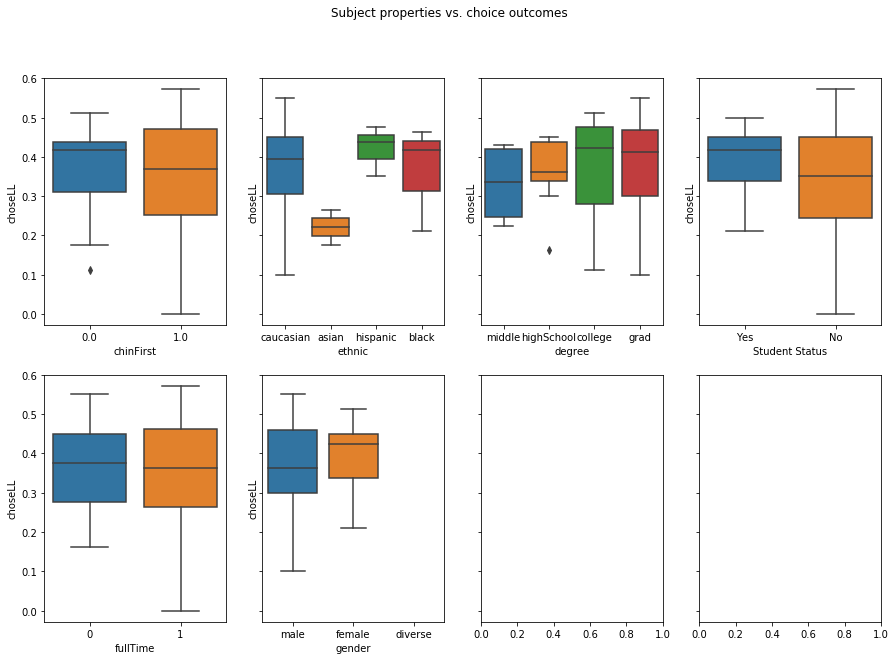

In [5]:
fig, axes = plt.subplots(2, 4, sharey=True, figsize=(3*5, 2*5))
fig.suptitle('Subject properties vs. choice outcomes')

predictors = ['chinFirst', 'ethnic', 'degree', 'Student Status']  
for i in range(0, len(predictors)):
    sns.boxplot(ax=axes[0, i], x=predictors[i], y='choseLL', 
                data=data_subject.loc[data_subject['status'].isin(['APPROVED', 'NOTPROLIFIC'])])
predictors = ['fullTime', 'gender']  
for i in range(0, len(predictors)):
    sns.boxplot(ax=axes[1, i], x=predictors[i], y='choseLL', 
                data=data_subject.loc[data_subject['status'].isin(['APPROVED', 'NOTPROLIFIC'])])

In [6]:
for col in ['Nationality', 'Country of Birth']:
    print(pd.crosstab(index=data_subject[col], columns="count"))
    print('\n')

col_0            count
Nationality           
CONSENT REVOKED      1
Germany              1
Greece               3
Hungary              1
Israel               2
Italy                6
Mexico               2
Poland              14
Portugal             3
Serbia               1
South Africa         1
Spain                4
United Kingdom      10
United States        1


col_0             count
Country of Birth       
CONSENT REVOKED       1
Germany               2
Greece                2
Hong Kong             1
Hungary               1
Israel                2
Italy                 6
Mexico                2
New Zealand           1
Poland               14
Portugal              3
Serbia                1
South Africa          1
Spain                 4
United Kingdom        9




# Visualize eye movements

## Individual

In [7]:
data_plot = data_et_choice.loc[data_et_choice['run_id']==43, :]

def add_var_to_data_et(data_et, source_data, varName):
    if varName in data_et.columns: data_et=data_et.drop(columns=varName)
    data_et = data_et.merge(
        source_data.loc[:, ['run_id', 'trial_index', varName]], 
        on=['run_id', 'trial_index'], how='left')
    return data_et

data_plot = add_var_to_data_et(data_plot, data_trial_choice, 'trial_duration_exact')
data_plot['t_task_rel'] = data_plot['t_task'] / data_plot['trial_duration_exact']

C:\Users\User\Anaconda3\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


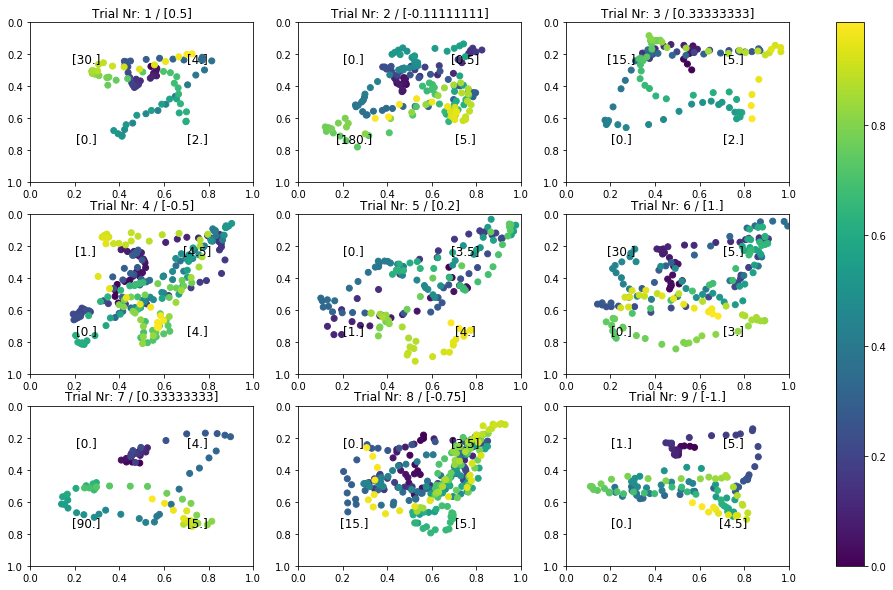

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(17, 10))
axes = axes.ravel()

xPos = [0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.2, 0.5, 0.8]
yPos = [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8]
thisSubject = data_plot['run_id'].unique()[0]

for i in range(0, 9):
    
    df_thisTrial = data_trial_choice.loc[
        (data_trial_choice['run_id']==thisSubject) &
        (data_trial_choice['withinTaskIndex']==i+1), :]
    
    payne = df_thisTrial['payneIndex'].values
    
    axes_data = data_plot.loc[data_plot['withinTaskIndex']==i+1, :]
    im = axes[i].scatter(axes_data['x'], axes_data['y'], c=axes_data['t_task_rel'], cmap='viridis')
    axes[i].set_title('Trial Nr: ' + str(i+1) + ' / ' + str(payne))
    axes[i].set_ylim(1, 0)
    axes[i].set_xlim(0, 1)
    
    # JS and python y coordinates seem to be inverted
    axes[i].text(0.25, 0.75, df_thisTrial['option_topLeft'].values, 
                 size=12, ha="center", transform=axes[i].transAxes)
    axes[i].text(0.25, 0.25, df_thisTrial['option_bottomLeft'].values, 
                 size=12, ha="center", transform=axes[i].transAxes)
    axes[i].text(0.75, 0.75, df_thisTrial['option_topRight'].values, 
                 size=12, ha="center", transform=axes[i].transAxes)
    axes[i].text(0.75, 0.25, df_thisTrial['option_bottomRight'].values, 
                 size=12, ha="center", transform=axes[i].transAxes)
    
fig.colorbar(im, ax=axes)
plt.show()

## Heatmap

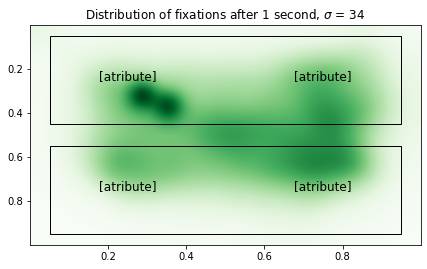

<Figure size 432x288 with 0 Axes>

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter


x = data_et_choice.loc[data_et_choice['t_task']>1000, 'x']
y = data_et_choice.loc[data_et_choice['t_task']>1000, 'y']

def myplot(x, y, s, bins=[1200, 675]):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)
    extent = [xedges[0], xedges[-1], yedges[-1], yedges[0]]
    return heatmap.T, extent



s# Create figure and axes
fig,ax = plt.subplots(figsize=(7, 7))

s=34
img, extent = myplot(x, y, s=s)
ax.imshow(img, extent=extent, origin='upper', cmap=cm.Greens, aspect=(9/16))

rect = patches.Rectangle((0.05,0.05),0.9,0.4,linewidth=1, edgecolor='black',facecolor='none')
ax.add_patch(rect)
rect = patches.Rectangle((0.05,0.55),0.9,0.4,linewidth=1, edgecolor='black',facecolor='none')
ax.add_patch(rect)

xPos = [0.25, 0.75, 0.25, 0.75]
yPos = [0.25, 0.25, 0.75, 0.75]
for i in range(0, len(xPos)):
    plt.text(xPos[i], yPos[i], '[atribute]', size=12, ha="center")

ax.set_title("Distribution of fixations after 1 second, $\sigma$ = %d" % s)

plt.show()
plt.savefig('plots/choice_heatmap.png')

# Correlations

## AVG reaction time for each subject

## subject-level

In [35]:
data_plot = data_subject.loc[
    data_subject['run_id'].isin(data_trial_choice['run_id'].unique()), :]

corr_columns = ['birthyear', 'choseLL', 'attributeIndex', 'optionIndex', 'payneIndex', 'choice_rt']
sns.pairplot(data_plot.loc[:, np.append(corr_columns, ['chinFirst'])], hue='chinFirst')

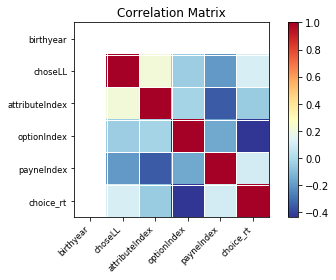

,birthyear,choseLL,attributeIndex,optionIndex,payneIndex,choice_rt
birthyear,-,,,,,
choseLL,-0.244,-,,,,
attributeIndex,0.056,0.218,-,,*,
optionIndex,0.1,-0.043,-0.017,-,,**
payneIndex,0.071,-0.197,-0.347,-0.16,-,
choice_rt,-0.107,0.12,-0.046,-0.436,0.104,-


In [37]:
corr_matrix = np.corrcoef(data_plot[corr_columns].T)
smg.plot_corr(corr_matrix, xnames=data_plot[corr_columns].columns)
plt.show()
data_plot[corr_columns].rcorr()

In [38]:
data_plot[corr_columns].rcorr(upper='n')

,birthyear,choseLL,attributeIndex,optionIndex,payneIndex,choice_rt
birthyear,-,50,50,50,50,50
choseLL,-0.244,-,52,52,52,52
attributeIndex,0.056,0.218,-,52,52,52
optionIndex,0.1,-0.043,-0.017,-,52,52
payneIndex,0.071,-0.197,-0.347,-0.16,-,52
choice_rt,-0.107,0.12,-0.046,-0.436,0.104,-


## trial-level

C:\Users\User\Anaconda3\lib\site-packages\numpy\core\_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\User\Anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\numpy\core\_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\User\Anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


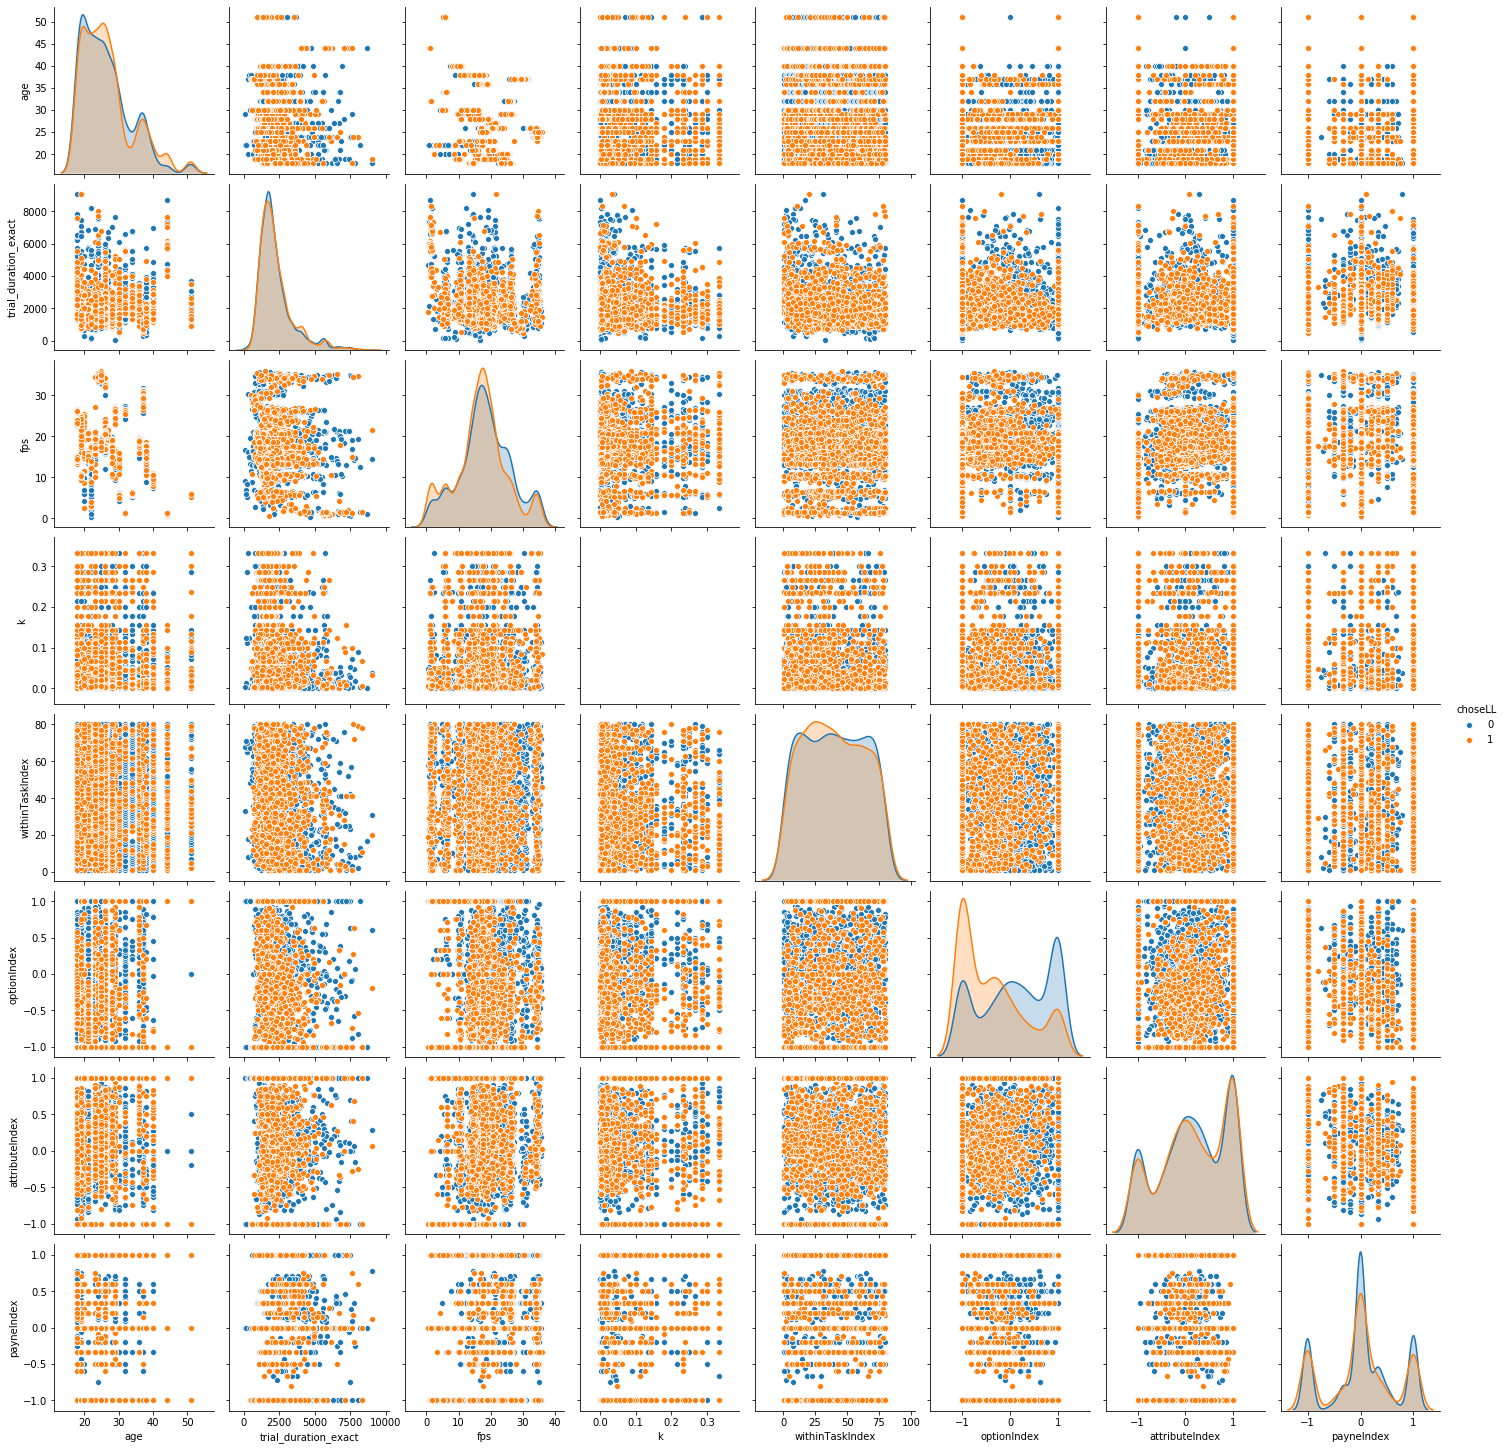

In [9]:
corr_columns = ['trial_duration_exact', 'fps', 'k', 'withinTaskIndex', 
                'optionIndex', 'attributeIndex', 'payneIndex']

sns.pairplot(data_trial_choice.loc[:, np.append(corr_columns, ['choseLL'])], hue='choseLL')